In [1]:
# Library import
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import jax.numpy as jnp 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv', index_col=0)
df_glcparameter = pd.read_csv('parameter.csv',index_col=0)

In [3]:
x_scaled = train['x_scaled'].values
y_scaled = train['Y_inhibit'].values
Mol_ID= train['Mol_ID'].values

In [4]:
def model_IC50(Mol_ID, x_scaled, y_scaled=None):
    g = numpyro.sample("g", dist.HalfCauchy(5.0))

    
    n_Mol_ID = len(np.unique(Mol_ID))

    with numpyro.plate("plate_i", n_Mol_ID):
        β = numpyro.sample("β", dist.HalfCauchy(1.0))

    
    mu = 1/(1+(x_scaled/β[Mol_ID])**g)
    sc = numpyro.sample('sc', dist.HalfCauchy(5) )

    with numpyro.plate("N", len(x_scaled)):
        numpyro.sample('obs', dist.Normal(mu, sc),  obs = y_scaled)


In [5]:
nuts = numpyro.infer.NUTS(model_IC50)

mcmc_IC50 = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc_IC50.run(jax.random.PRNGKey(0), Mol_ID, x_scaled, y_scaled)

trace_IC50 = mcmc_IC50.get_samples()

idata_IC50 = az.from_numpyro(mcmc_IC50)

<ipython-input-5-1f3e55f70218>:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_IC50 = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)
sample: 100%|██████████| 3500/3500 [00:00<00:00, 8034.07it/s, 15 steps of size 2.33e-01. acc. prob=0.75]


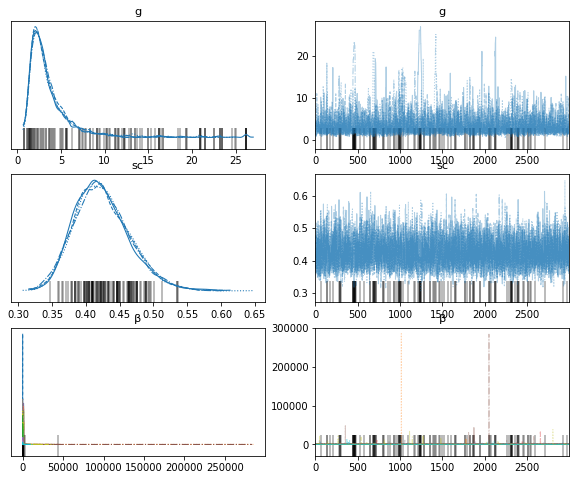

In [10]:
az.plot_trace(idata_IC50,figsize=(10, 8), combined=False);

In [12]:
def create_prediction_template(unique_Mol_ID, X_range):
    unique_Mol_ID["_temp"] = True
    X_temp = pd.DataFrame(X_range, columns=["X"])
    X_temp["_temp"] = True
    return unique_Mol_ID.merge(X_temp, on="_temp").drop(["_temp"], axis=1)


In [13]:

u_Mol_ID = train[["Mol_Name", "Mol_ID"]].drop_duplicates()
X_range = jnp.linspace(0, 3, 75)
pred_template = create_prediction_template(u_Mol_ID, X_range)

In [14]:
pf_Mol_ID = pred_template["Mol_ID"].values
pf_x_scaled = pred_template["X"].values
predictive_IC50 = numpyro.infer.Predictive(model_IC50, trace_IC50)
ppc_samples_IC50 = predictive_IC50(jax.random.PRNGKey(1), pf_Mol_ID, pf_x_scaled, None)
idata_ppc_IC50 = az.from_numpyro(mcmc_IC50, posterior_predictive=ppc_samples_IC50)



In [15]:
df_ppc_IC50 = pred_template.copy()
df_ppc_IC50["Y_pred"] = ppc_samples_IC50["obs"].T.mean(axis=1)
df_ppc_IC50["sigma"] = ppc_samples_IC50["obs"].T.std(axis=1)
# HDI (Highest Density interval) Mean +/- sigma --> 68% CI (Confidence Interval)
df_ppc_IC50["Y_inf"] = df_ppc_IC50["Y_pred"] - df_ppc_IC50["sigma"]
df_ppc_IC50["Y_sup"] = df_ppc_IC50["Y_pred"] + df_ppc_IC50["sigma"]

In [16]:
def chart_predictions_IC50(Mol_Name, ax):
    data_ppc_IC50 = df_ppc_IC50[df_ppc_IC50["Mol_Name"] == Mol_Name]
    x_ppc_IC50 = data_ppc_IC50["X"].values
    data_obs_IC50 = train[train['Mol_Name']== Mol_Name]
    x_obs_IC50 = data_obs_IC50['Mean X_um2'].values/100
    ax.set_title(Mol_Name)
    ax.set_xlim(0, 3)
    ax.set_ylim(-0.2, 2)
    ax.plot(x_obs_IC50, data_obs_IC50["Y_inhibit"], "o", markersize=12, color="black")
    ax.plot(x_ppc_IC50, data_ppc_IC50["Y_pred"].values, lw=6, alpha=1, color="red")
    ax.hlines(y=0, xmin = 0, xmax = 3, colors = "grey", linestyles='dashed')
    ax.fill_between(x_ppc_IC50, data_ppc_IC50["Y_inf"], data_ppc_IC50["Y_sup"], color="lavender")

In [18]:
N_Mol_ID = len(np.unique(Mol_ID))

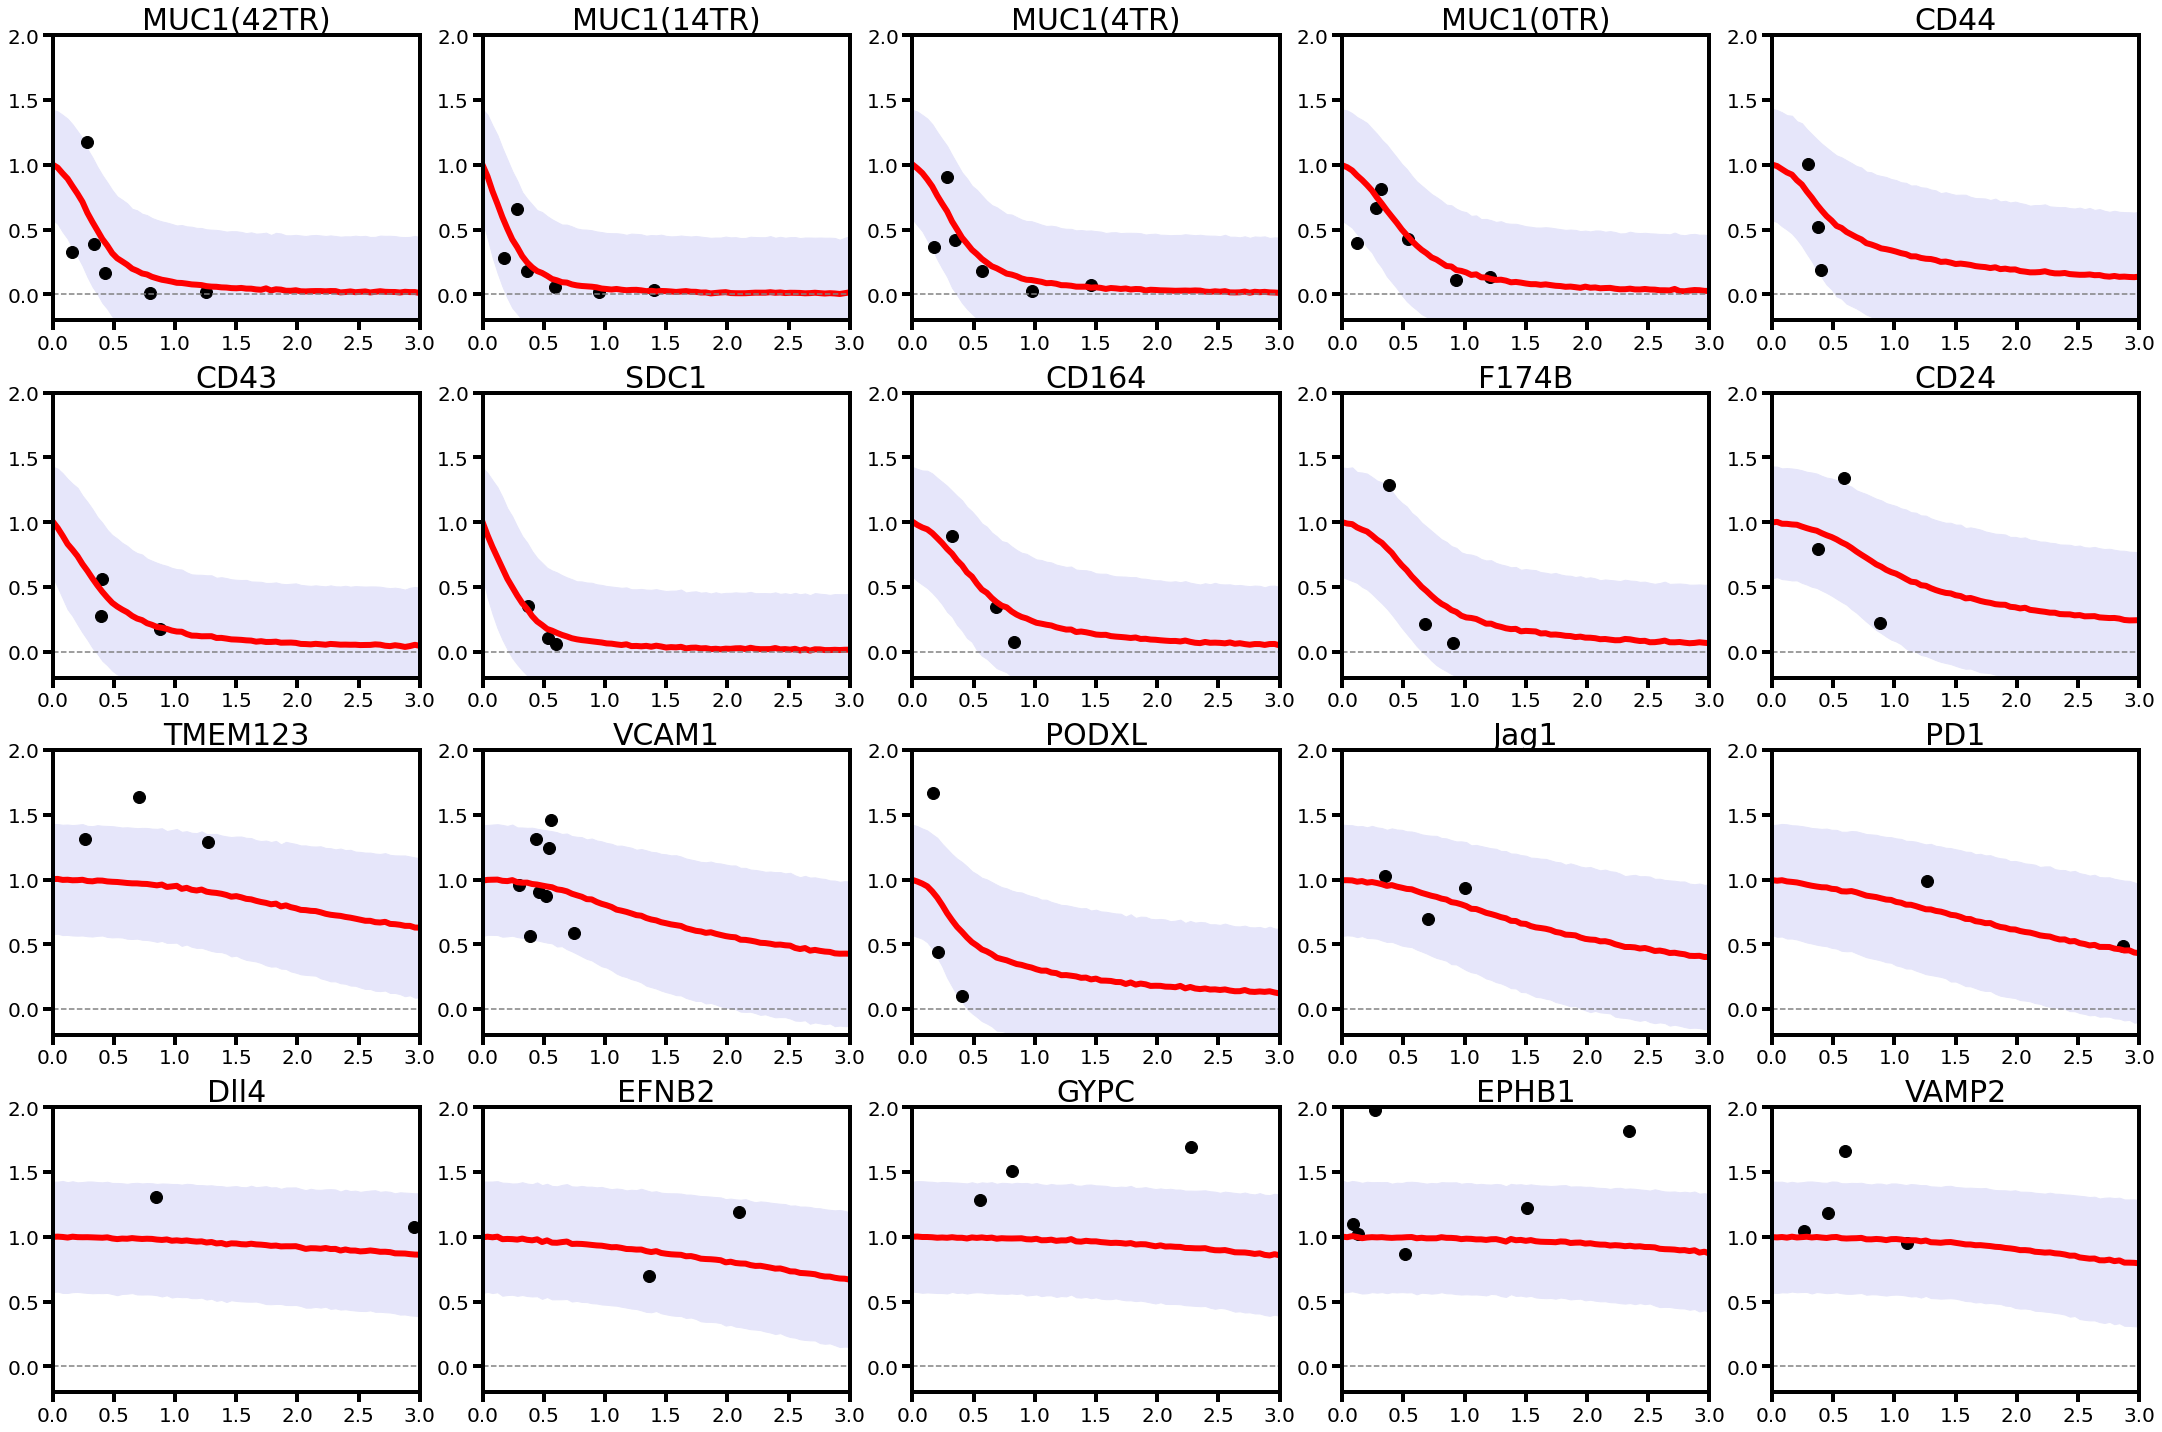

In [19]:
fig = plt.figure(figsize=(30, 20))

for k in range(N_Mol_ID):
    ax = fig.add_subplot(4, 5, k+1)
    
    uMoltemp = u_Mol_ID[u_Mol_ID['Mol_ID']==k]
    Mol_Name= uMoltemp.iloc[0]['Mol_Name']
    
    chart_predictions_IC50(Mol_Name, ax)
    
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4)

    # increase tick width
    ax.tick_params(width=4, length = 10, labelsize=20)
    ax.tick_params(which='minor', width=2, length=6)
    
    ax.set_title(Mol_Name, fontsize=30)

plt.tight_layout()